In [3]:
from collections import defaultdict
import json
import glob
import os
import sys
from typing import Tuple

import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd

from source import load_avenio_files
from fragment_count.utils import load_samples_as_data_frame
from fragment_count.views import plot_distribution_comparison, plot_distribution

In [4]:
patient_mutations, clinical_data = load_avenio_files()

In [5]:
respond = clinical_data['response_grouped'] == 'responder (pr+cr)'
response_id = clinical_data[respond].index
non_response_id = clinical_data[~respond].index

In [6]:
response_samples = []
non_response_samples = []

for ptid in response_id:
    response_samples += glob.glob(f'fragment_count/output/tumor_derived/{ptid}*.json')
    
for ptid in non_response_id:
    non_response_samples += glob.glob(f'fragment_count/output/tumor_derived/{ptid}*.json')

In [11]:
from collections import defaultdict
import json
from typing import Iterable, Tuple

import pandas as pd
from fragment_count.utils import _json_to_data_frame

def load_samples_as_data_frame(filenames: Iterable[str]) -> pd.DataFrame:
    """
    Concatenate sample data frames in one monolithic multi-index data frame.
    """
    # Cache data frames per sample.
    normal_variant_pairs = [_json_to_data_frame(f) for f in filenames]
    normals, variants = zip(*normal_variant_pairs)
    # Determine domain of the samples.
    indices, columns = compute_domain(tuple(normals) + tuple(variants))
    kwargs = {"index": indices, "columns": columns, "dtype": int}

    def _concatenate(data_frames):
        items = [pd.DataFrame(0, **kwargs).add(df, fill_value=0) for df in data_frames]

        names = [tuple(f.split("/")[-1].split(".")[0].split("_")) for f in filenames]
        panel = pd.concat(
            items, keys=names, names=["Patient ID", "sample number", "length (bp)"], axis=0
        )
#         panel.index.set_names(["sample", "length (bp)"], inplace=True)
        return panel

    return _concatenate(normals), _concatenate(variants)

In [30]:
resp_normal, resp_var = load_samples_as_data_frame(response_samples)
non_resp_normal, non_resp_var = load_samples_as_data_frame(non_response_samples)

In [138]:
def pool(df):
    return df.sum(axis=1).groupby("length (bp)").sum().astype(int)

def pool_patient_samples(data_frame):
    # Combine baseline and follow up samples.
    return data_frame.groupby(['Patient ID', 'length (bp)']).sum()

def safe_normalise(x):
    """ Turn counts into normalised distribution. """
    Z = x.sum()
    if Z != 0.0:
        return x/Z
    return x

def filter_no_fragments(data_frame):
    # Patients with zero fragment count, over all genes.
    clearance = data_frame.groupby('Patient ID').sum() == 0
    return data_frame[~clearance[data_frame.index.get_level_values('Patient ID')].values]

def pool_and_normalise(data_frame):
    return pool_patient_samples(resp_normal).sum(axis=1).groupby('Patient ID').apply(safe_normalise)

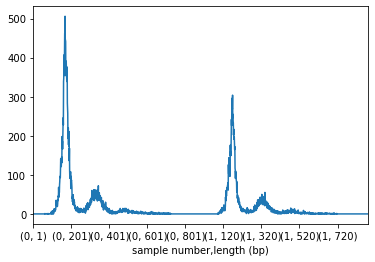

In [140]:
new_df.sum(axis=1).loc['1023'].plot()

(80, 400)

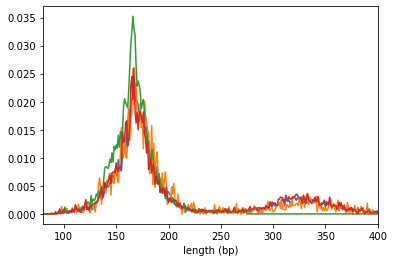

In [71]:
pool_and_normalise(resp_normal).loc['1023'].plot()
pool_and_normalise(resp_normal).loc['1031'].plot()
pool_and_normalise(resp_normal).loc['982'].plot()
pool_and_normalise(resp_normal).loc['1035'].plot()
fragment_window = [80, 400]
plt.xlim(fragment_window)

In [141]:
def plot_distribution(seq, label=None, with_peaks=True): 
    # Combine baseline and follow-up.
    df = pool_patient_samples(seq)
    # Remove patients with no fragments at both base line and follow up.
    df = filter_no_fragments(df)
    # Normalise as probability.
    distributions = df.groupby('Patient ID').apply(safe_normalise)
    
    mean = distributions.groupby('length (bp)').mean()
    std = distributions.groupby('length (bp)').std()
    fragment_window = [80, 400]
    print('integral', mean.sum())
    
    n = distributions.index.get_level_values('Patient ID').nunique()
    mean.plot(label=label + ' (n={})'.format(n))
    upper_bound = mean + std
    lower_bound = mean - std
    plt.fill_between(mean.index, upper_bound, lower_bound, alpha=0.25)
    
    plt.xlim(fragment_window)

integral 1.0
integral 1.0000000000000002


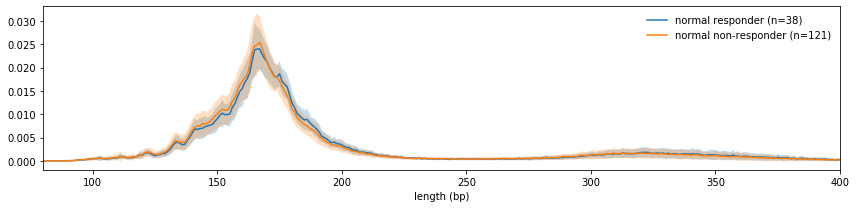

In [143]:
plt.figure(figsize=(12,3))
plot_distribution(resp_normal.sum(axis=1), label='normal responder')
plot_distribution(non_resp_normal.sum(axis=1), label='normal non-responder')
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig('figs/normals.png')

integral 1.0
integral 1.0


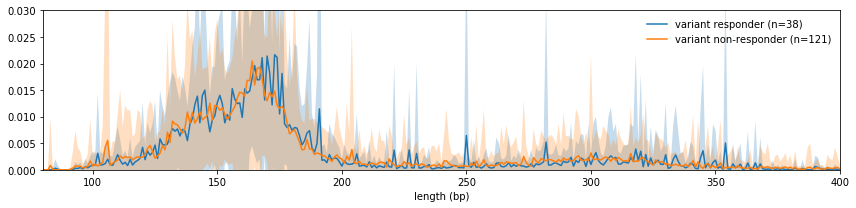

In [144]:
plt.figure(figsize=(12,3))
plot_distribution(resp_var.sum(axis=1), label='variant responder')
plot_distribution(non_resp_var.sum(axis=1), label='variant non-responder')
plt.legend(frameon=False)
plt.ylim([0.0, 0.03])
plt.tight_layout()
plt.savefig('figs/variants.png')

In [74]:
plt.figure(figsize=(12,3))
figure_labels = {
    'resp_normal': f'normal resp (n={pool(resp_normal).sum()})',
    'non_resp_normal': f'normal non-resp (n={pool(non_resp_normal).sum()})',
    'resp_variant': f'variant resp (n={pool(resp_var).sum()})',
    'non_resp_variant': f'variant non-resp (n={pool(non_resp_var).sum()})',
}
with mpl.rc_context(rc={'lines.linestyle':'-'}):
    plot_distribution(
        pool(resp_normal), 
        label=figure_labels['resp_normal'], 
        with_peaks=False,
    )
    plot_distribution(
        pool(non_resp_normal), 
        label=figure_labels['non_resp_normal'], 
        with_peaks=False,
    )
    
# with plt.style.context('linestyle'):
with mpl.rc_context(rc={'lines.linestyle':'--'}):
    plot_distribution(
        pool(resp_var), 
        label=figure_labels['resp_variant'], 
        with_peaks=False,
    )
    plot_distribution(
        pool(non_resp_var), 
        label=figure_labels['non_resp_variant'], 
        with_peaks=False,
    )
    plt.legend(frameon=False)
plt.savefig('figs/distributions_with_response.png')

KeyError: 'Patient ID'

<Figure size 864x216 with 0 Axes>

In [75]:
plt.figure(figsize=(12,3))
plot_distribution_comparison(
    pool(resp_normal).sum(axis=1), 
    non_resp_normal.sum(axis=1),
    labels=[figure_labels['resp_normal'], figure_labels['non_resp_normal']],
    filename_suffix='response_normal',
)
plt.savefig('figs/normal_response.png')
plt.figure(figsize=(12,3))
plot_distribution_comparison(
    resp_var.sum(axis=1), 
    non_resp_var.sum(axis=1),
    labels=[figure_labels['resp_variant'], figure_labels['non_resp_variant']],
    filename_suffix='response_variant',
)
plt.savefig('figs/variant_response.png')

ValueError: No axis named 1 for object type <class 'pandas.core.series.Series'>

<Figure size 864x216 with 0 Axes>